## CITS4404 Practical Project

### Group 3 

##### Callum Brown – 22985036
##### Djimon Jayasundera - 23061402
##### Christopher -  22732248
##### Doris (Chuanrui Yang) – 23786945

In [24]:
''' IMPORTS '''
import numpy as np
import imageio.v3 as iio
import random, copy
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances
import cv2
from shapely.geometry import LineString
import time

''' GLOBAL VARIABLES '''
# miscellaneous
rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images
# for image prep
IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax
# for timing
start_time = time.time()
function_times = {}

''' OPERATIONAL FUNCTIONS '''
# Read, crop and display image and stats
''' IMAGE PREP '''
def crop (image, mask):
    if len(image.shape) == 3:  # Check if the image has color channels
        # Convert image to grayscale using luminosity to retain intensity variance (contrast)
        image = 0.2989 * image[:, :, 0] + 0.5870 * image[:, :, 1] + 0.1140 * image[:, :, 2]
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

''' TIMING '''
def measure_time(f):
    def timed(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        function_time = te - ts
        if f.__name__ not in function_times:
            function_times[f.__name__] = [0, 0]  # [total_time, call_count]
        function_times[f.__name__][0] += function_time
        function_times[f.__name__][1] += 1
        return result
    return timed

def print_function_times():
    end_time = time.time()
    total_program_time = end_time - start_time
    print()
    print("### PROFILING ###")
    print("Total program time: {:.2f} sec".format(total_program_time))
    print("Function times:")
    for function_name, (total_time, call_count) in function_times.items():
        percentage = (total_time / total_program_time) * 100
        average_time = total_time / call_count
        print("- {}: {:.2f} sec ({:.2f}%), {} calls".format(
            function_name, total_time, percentage, call_count, average_time))
    print()

''' WORM INITALISATIONS '''
def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)

# Initialise a random clew
def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

In [25]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def bezier_tangent(self, t):
        P0, P1, P2 = self.control_points()
        return 2 * (1 - t) * (P1 - P0) + 2 * t * (P2 - P1)
    
    @measure_time
    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        height, width = image.shape[:2]
        intermediates[:, 0] = np.clip(intermediates[:, 0], 0, width - 1)
        intermediates[:, 1] = np.clip(intermediates[:, 1], 0, height - 1)
        colours = [image[point[1],point[0]] for point in intermediates] #? had to swap point[1] and point[0] cause y and x were in the other order
        return(np.array(colours)/255)
    
    @measure_time
    def colour_along_width(self, image):
        # set last value for n points to look at width
        t_values = np.linspace(0, 1, 3)
        points = self.bezier.point_at_t(t_values)
        tangents = np.array([self.bezier_tangent(t) for t in t_values])
        normal_vectors = np.stack((-tangents[:, 1], tangents[:, 0]), axis=-1)  # Rotate tangent vectors by 90 degrees
        color_samples = []
        half_width = self.width / 2
        epsilon = 1e-8  # Small value to avoid division by zero
        image_height, image_width = image.shape[:2]
        for point, normal in zip(points, normal_vectors):
            normal_length = np.linalg.norm(normal)
            if normal_length < epsilon:
                normal_length = epsilon
            normal = normal / normal_length * half_width  # Normalize and scale to half width
            left_point = point - normal
            right_point = point + normal
            # Ensuring the points are within image bounds (approximate)
            left_point = np.clip(left_point.astype(int), [0, 0], [image_width - 1, image_height - 1])
            right_point = np.clip(right_point.astype(int), [0, 0], [image_width - 1, image_height - 1])
            # Sample colors (approximate)
            left_color = image[left_point[1], left_point[0]]
            right_color = image[right_point[1], right_point[0]]
            # Average the colors
            average_color = (left_color + right_color) / 2
            color_samples.append(average_color)
        return np.array(color_samples) / 255  # Normalize if needed

    @measure_time
    def img_color_across_t(self, t, image):
        # average image colour across all points in t 
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        try:
            return np.array(image[intermediates[:, 1], intermediates[:, 0]]) / 255.0
        except:
            return np.array([0 for _ in range(len(t))])

In [26]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms, alpha=1.0, colour=None):
        colourmap = mpl.colormaps["rainbow"]
        try:
            for worm in worms:
                patch = worm.patch()
                patch.set_alpha(alpha)
                if colour != None:
                    patch.set_edgecolor(colourmap(colour))
                self.ax.add_patch(patch)
        except TypeError:
            patch = worms.patch()
            patch.set_alpha(alpha)
            if colour != None:
                patch.set_edgecolor(colourmap(colour))
            self.ax.add_patch(patch)

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()

In [27]:
"""
Each fitness represents a score for a random worm
"""
class Fitness:
    def __init__(self, image, swarms):
        self.image = image
        self.swarms = swarms
        self.times = {}
        
    @measure_time
    def get(self, worm):
        img_height, img_width = self.image.shape[:2]

        # obtain internal score
        def internal_fitness():
            @measure_time
            # width factor
            def width():
                # example weakly encouraging width to be 8
                return (1 / max(abs(worm.width - 4),1),5) 

            @measure_time
            # length factor
            def length():
                # provides benefit up to a value of img_width/8 then no more benefit
                if worm.r < 5:
                    return (0,0)
                return (1,1)

            internal_factors = [width(), length()]
            return sum([x[0] * x[1] for x in internal_factors])

        # obtain group score
        def group_fitness():
            @measure_time
            # distance between swarms
            def worm_spread():
                closest_worm = None
                min_distance = float('inf')  # Initialize with a large number
                avgs = []
                # Iterate through each swarm and each worm within the swarm
                for s in swarms:
                    if s in swarms[::len(swarms)//10]:
                        avgs.append(s.population[0])
                    if worm not in s.population:  # Ensure not checking the worm's own swarm
                        other_worm = s.population[0]
                        # Calculate Euclidean distance
                        distance = ((worm.x - other_worm.x) ** 2 + (worm.y - other_worm.y) ** 2) ** 0.5
                        if distance < min_distance:
                            min_distance = distance
                            closest_worm = other_worm  # Update the closest worm
                # Apply upper limit to distance based on image dimensions and number of swarms
                distance_limit = min(min_distance, min(img_width, img_height) * 2 / np.ceil(len(swarms) ** 0.5))
                # Normalize the distance
                normalized_distance = distance_limit / (min(img_width, img_height) / np.ceil(len(swarms) ** 0.5))
                return (normalized_distance, 1.2, closest_worm, avgs)
        
            # detect if the worm is crossing another, penalise heavily
            @measure_time
            def cross_factor(avgs):
                line1 = LineString(worm.path().vertices)
                for other_worm in avgs:
                    line2 = LineString(other_worm.path().vertices)
                    # Check if the lines intersect and that the intersection is not just touching
                    if line1.intersects(line2) and not line1.touches(line2):
                        return (-1,5)
                return (0,0)

            # detect if the worm is roughly parallel with its closest friend
            @measure_time
            def parallelism(closest_worm):
                r1 = worm.theta
                r2 = closest_worm.theta
                angle_diff = np.abs(r1 - r2)
                angle_diff = min(angle_diff, 2*np.pi - angle_diff)  # This accounts for wrapping around the circle
                # Normalize the difference to a score from 0 to 1
                # Maximum difference that affects parallelism is pi (180 degrees)
                similarity_score = 1 - (angle_diff / np.pi)  # Normalize the difference by pi
                return (similarity_score,0.2)

            worm_spread = worm_spread()
            group_factors = [worm_spread, cross_factor(worm_spread[3]), parallelism(worm_spread[2])]
            return sum([x[0] * x[1] for x in group_factors])

        # obtain environmental score
        def environmental_fitness():
            @measure_time
            # colour factor
            def path_colour():
                DIVISIONS = 14
                # points along centre path 
                t = np.linspace(0,1,DIVISIONS)
                path_colour = worm.img_color_across_t(t, self.image)
                ps = 1 - np.mean(np.abs(worm.colour - path_colour))
                # subtract from 1 since higher fitness is better
                return (ps, 5)

            def width_colour():
                width_colour = worm.colour_along_width(self.image)
                ws = 1 - np.mean(np.abs(worm.colour - width_colour))
                return (ws, 1)
                
            @measure_time
            # discourage from going out of bounds
            def outside():
                min_x, min_y = np.min(worm.control_points(), axis=0)
                max_x, max_y = np.max(worm.control_points(), axis=0)
                if min_x < 0 or max_x >= img_width or min_y < 0 or max_y >= img_height:
                    return (-1, 1)  # high cost for going outside
                else:
                    return (0, 0) # doesn't affect worm if it's inside boundaries

            environmental_factors = [path_colour(), width_colour(), outside()]
            return sum([x[0] * x[1] for x in environmental_factors])

        # driver weights
        Wi = 1
        Wg = 1
        We = 1
        # driver costs
        Ci = internal_fitness()
        Cg = group_fitness()
        Ce = environmental_fitness()
        # implement cost/fitness function
        fitness = (Wi*Ci) + (Wg*Cg) + (We*Ce)
        return fitness

In [28]:
"""
Each Swarm represents a single worm 
"""
class Swarm:
    def __init__ (self, image, population):
        self.image = image
        self.population = population
        self.fitness = None # must be updated after Fitness class is created
        
        # CONSTANTS #
        # number of individuals in the selection tournament
        # a higher tnm_k means it will select more of the best, and less of the worst
        # may converge faster without as much exploration
        self.tnm_k = 3
        # rate of mutation which should be between 0 and 1
        # a high rate may prevent convergence, a low rate will need more iterations to converge
        self.m_rate = 0.01 
        
    @measure_time
    def update(self):
        assert(self.fitness != None)
        fitnesses = [fitness.get(x) for x in self.population]
        new_population = []
        size = len(self.population)
        for i in range(size):
            # tournament selection
            selected_ix = random.randint(0,size-1)
            for ix in [random.randint(0,size-1) for x in range(self.tnm_k-1)]:
                if fitnesses[ix] > fitnesses[selected_ix]:
                    selected_ix = ix
            parent = self.population[selected_ix]
            # mutating
            height, width = image.shape[:2]
            c_x = min(max(parent.x + random.uniform(-self.m_rate*width/2,self.m_rate*width/2),0),width)
            c_y = min(max(parent.y + random.uniform(-self.m_rate*height/2,self.m_rate*height/2),0),height)
            max_r = max(width,height)/2
            c_r = min(max(parent.r + random.uniform(-self.m_rate*max_r/2,self.m_rate*max_r/2),0),max_r)
            c_colour = min(max(parent.colour + random.uniform(-self.m_rate/2,self.m_rate/2),0),1)
            c_theta = (parent.theta + random.uniform(-self.m_rate*np.pi,self.m_rate*np.pi)) % (np.pi*2)
            c_dr = min(max(parent.dr + random.uniform(-self.m_rate*c_r,self.m_rate*c_r),-c_r),c_r)
            c_dgamma = min(max(parent.dgamma + random.uniform(-self.m_rate*np.pi,self.m_rate*np.pi),-np.pi),np.pi)
            c_width = min(max(parent.width + random.uniform(-self.m_rate*c_r,self.m_rate*c_r),1),2*c_r)
            # child
            child = Camo_Worm(c_x, c_y, c_r, c_theta, c_dr, c_dgamma, c_width, c_colour)
            new_population.append(child)
        self.population = new_population

    @measure_time
    def avg_worm(self):
        avg = copy.deepcopy(self.population[0])
        for field in ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width']:
            setattr(avg, field, np.mean([getattr(w, field) for w in self.population]))
        return avg
    

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


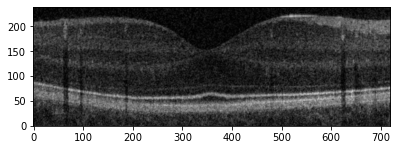

C:\Users\calsp\AppData\Local\Temp\ipykernel_9988\1156214782.py:73: RuntimeWarning: overflow encountered in scalar add
  average_color = (left_color + right_color) / 2


Iteration: 1
Time Remaining: 97 seconds
Fitness: [8.53, 7.83, 6.08, 8.53, 9.72, 8.99, 8.58, 7.78, 9.14, 9.08]
Mutation Rate: 0.1
Tournament Size: 2

### PROFILING ###
Total program time: 0.49 sec
Function times:
- width: 0.00 sec (0.21%), 600 calls
- length: 0.00 sec (0.00%), 600 calls
- worm_spread: 0.01 sec (1.64%), 600 calls
- cross_factor: 0.15 sec (29.99%), 600 calls
- parallelism: 0.00 sec (0.41%), 600 calls
- img_color_across_t: 0.02 sec (4.91%), 600 calls
- path_colour: 0.05 sec (9.70%), 600 calls
- colour_along_width: 0.07 sec (13.94%), 600 calls
- outside: 0.01 sec (2.24%), 600 calls
- get: 0.31 sec (62.84%), 600 calls
- update: 0.15 sec (30.39%), 10 calls



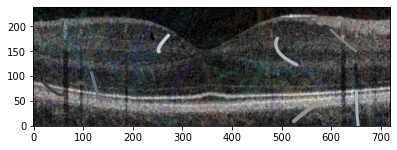


Iteration: 20
Time Remaining: 41 seconds
Fitness: [10.9, 9.98, 10.9, 11.2, 11.1, 9.81, 10.4, 10.6, 9.89, 12.2]
Mutation Rate: 0.0752
Tournament Size: 2

### PROFILING ###
Total program time: 4.66 sec
Function times:
- width: 0.02 sec (0.42%), 6600 calls
- length: 0.00 sec (0.00%), 6600 calls
- worm_spread: 0.17 sec (3.71%), 6600 calls
- cross_factor: 1.83 sec (39.37%), 6600 calls
- parallelism: 0.03 sec (0.60%), 6600 calls
- img_color_across_t: 0.28 sec (6.01%), 6600 calls
- path_colour: 0.54 sec (11.58%), 6600 calls
- colour_along_width: 1.02 sec (21.80%), 6600 calls
- outside: 0.09 sec (2.03%), 6600 calls
- get: 3.91 sec (84.03%), 6600 calls
- update: 3.76 sec (80.68%), 200 calls
- avg_worm: 0.00 sec (0.04%), 10 calls



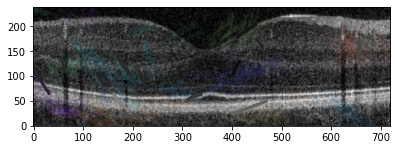


Iteration: 40
Time Remaining: 36 seconds
Fitness: [12.0, 11.4, 11.5, 13.0, 13.0, 11.2, 12.9, 11.5, 11.9, 11.6]
Mutation Rate: 0.0557
Tournament Size: 2

### PROFILING ###
Total program time: 9.02 sec
Function times:
- width: 0.03 sec (0.35%), 12900 calls
- length: 0.01 sec (0.06%), 12900 calls
- worm_spread: 0.31 sec (3.45%), 12900 calls
- cross_factor: 3.67 sec (40.72%), 12900 calls
- parallelism: 0.06 sec (0.63%), 12900 calls
- img_color_across_t: 0.58 sec (6.42%), 12900 calls
- path_colour: 1.04 sec (11.50%), 12900 calls
- colour_along_width: 1.97 sec (21.89%), 12900 calls
- outside: 0.21 sec (2.34%), 12900 calls
- get: 7.72 sec (85.62%), 12900 calls
- update: 7.59 sec (84.18%), 400 calls
- avg_worm: 0.01 sec (0.08%), 20 calls



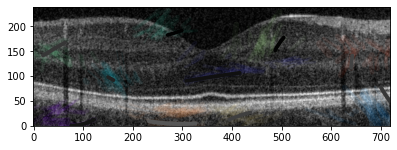


Iteration: 60
Time Remaining: 30 seconds
Fitness: [13.5, 12.2, 12.9, 12.6, 13.6, 13.0, 13.1, 13.2, 11.6, 13.1]
Mutation Rate: 0.0413
Tournament Size: 3

### PROFILING ###
Total program time: 12.94 sec
Function times:
- width: 0.04 sec (0.30%), 19200 calls
- length: 0.01 sec (0.05%), 19200 calls
- worm_spread: 0.45 sec (3.49%), 19200 calls
- cross_factor: 5.25 sec (40.55%), 19200 calls
- parallelism: 0.07 sec (0.58%), 19200 calls
- img_color_across_t: 0.82 sec (6.36%), 19200 calls
- path_colour: 1.47 sec (11.37%), 19200 calls
- colour_along_width: 2.90 sec (22.38%), 19200 calls
- outside: 0.29 sec (2.26%), 19200 calls
- get: 11.09 sec (85.67%), 19200 calls
- update: 10.99 sec (84.91%), 600 calls
- avg_worm: 0.01 sec (0.08%), 30 calls



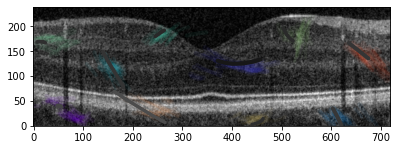


Iteration: 80
Time Remaining: 24 seconds
Fitness: [13.3, 13.8, 13.7, 13.6, 12.9, 13.0, 13.8, 13.3, 13.7, 13.9]
Mutation Rate: 0.0306
Tournament Size: 4

### PROFILING ###
Total program time: 16.66 sec
Function times:
- width: 0.05 sec (0.27%), 25500 calls
- length: 0.01 sec (0.04%), 25500 calls
- worm_spread: 0.55 sec (3.32%), 25500 calls
- cross_factor: 6.78 sec (40.70%), 25500 calls
- parallelism: 0.10 sec (0.62%), 25500 calls
- img_color_across_t: 1.05 sec (6.32%), 25500 calls
- path_colour: 1.91 sec (11.47%), 25500 calls
- colour_along_width: 3.70 sec (22.21%), 25500 calls
- outside: 0.37 sec (2.24%), 25500 calls
- get: 14.24 sec (85.48%), 25500 calls
- update: 14.16 sec (84.97%), 800 calls
- avg_worm: 0.01 sec (0.08%), 40 calls



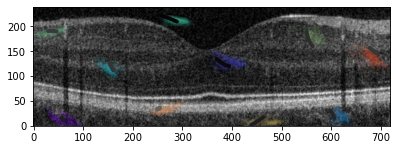


Iteration: 100
Time Remaining: 20 seconds
Fitness: [12.0, 13.3, 13.3, 13.6, 13.8, 12.7, 13.3, 13.5, 12.8, 13.6]
Mutation Rate: 0.0227
Tournament Size: 6

### PROFILING ###
Total program time: 20.40 sec
Function times:
- width: 0.06 sec (0.29%), 31800 calls
- length: 0.01 sec (0.05%), 31800 calls
- worm_spread: 0.69 sec (3.40%), 31800 calls
- cross_factor: 8.36 sec (41.01%), 31800 calls
- parallelism: 0.12 sec (0.61%), 31800 calls
- img_color_across_t: 1.29 sec (6.34%), 31800 calls
- path_colour: 2.33 sec (11.40%), 31800 calls
- colour_along_width: 4.53 sec (22.20%), 31800 calls
- outside: 0.45 sec (2.20%), 31800 calls
- get: 17.49 sec (85.75%), 31800 calls
- update: 17.44 sec (85.49%), 1000 calls
- avg_worm: 0.01 sec (0.07%), 50 calls



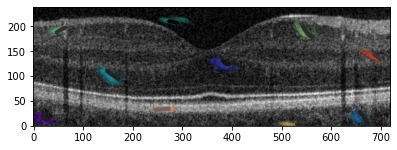


Iteration: 120
Time Remaining: 16 seconds
Fitness: [12.2, 12.1, 12.2, 13.1, 14.0, 13.6, 13.4, 12.6, 13.4, 12.9]
Mutation Rate: 0.0168
Tournament Size: 8

### PROFILING ###
Total program time: 24.06 sec
Function times:
- width: 0.07 sec (0.29%), 38100 calls
- length: 0.01 sec (0.05%), 38100 calls
- worm_spread: 0.81 sec (3.38%), 38100 calls
- cross_factor: 9.90 sec (41.16%), 38100 calls
- parallelism: 0.15 sec (0.61%), 38100 calls
- img_color_across_t: 1.53 sec (6.35%), 38100 calls
- path_colour: 2.76 sec (11.48%), 38100 calls
- colour_along_width: 5.35 sec (22.26%), 38100 calls
- outside: 0.52 sec (2.17%), 38100 calls
- get: 20.68 sec (85.95%), 38100 calls
- update: 20.64 sec (85.82%), 1200 calls
- avg_worm: 0.02 sec (0.07%), 60 calls



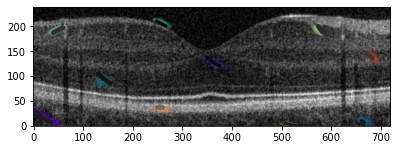


Iteration: 140
Time Remaining: 11 seconds
Fitness: [13.4, 11.3, 11.7, 13.2, 13.0, 13.8, 13.0, 13.2, 11.7, 13.9]
Mutation Rate: 0.0124
Tournament Size: 12

### PROFILING ###
Total program time: 27.78 sec
Function times:
- width: 0.08 sec (0.28%), 44400 calls
- length: 0.01 sec (0.05%), 44400 calls
- worm_spread: 0.93 sec (3.33%), 44400 calls
- cross_factor: 11.46 sec (41.26%), 44400 calls
- parallelism: 0.16 sec (0.57%), 44400 calls
- img_color_across_t: 1.77 sec (6.37%), 44400 calls
- path_colour: 3.21 sec (11.55%), 44400 calls
- colour_along_width: 6.15 sec (22.13%), 44400 calls
- outside: 0.61 sec (2.21%), 44400 calls
- get: 23.91 sec (86.07%), 44400 calls
- update: 23.91 sec (86.06%), 1400 calls
- avg_worm: 0.02 sec (0.07%), 70 calls



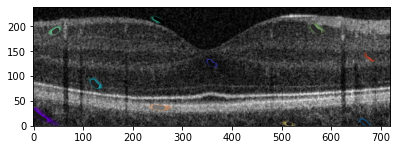


Iteration: 160
Time Remaining: 7 seconds
Fitness: [11.7, 11.7, 11.6, 12.7, 13.0, 13.7, 10.1, 12.2, 13.0, 13.1]
Mutation Rate: 0.00921
Tournament Size: 15

### PROFILING ###
Total program time: 31.66 sec
Function times:
- width: 0.09 sec (0.28%), 50700 calls
- length: 0.01 sec (0.04%), 50700 calls
- worm_spread: 1.05 sec (3.31%), 50700 calls
- cross_factor: 12.97 sec (40.96%), 50700 calls
- parallelism: 0.18 sec (0.58%), 50700 calls
- img_color_across_t: 2.03 sec (6.41%), 50700 calls
- path_colour: 3.66 sec (11.57%), 50700 calls
- colour_along_width: 7.04 sec (22.24%), 50700 calls
- outside: 0.70 sec (2.20%), 50700 calls
- get: 27.18 sec (85.86%), 50700 calls
- update: 27.21 sec (85.95%), 1600 calls
- avg_worm: 0.02 sec (0.07%), 80 calls



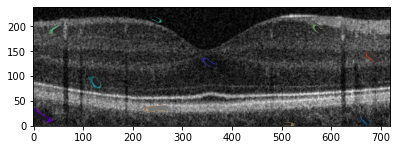


Iteration: 180
Time Remaining: 3 seconds
Fitness: [11.9, 11.1, 12.1, 13.0, 13.0, 13.8, 12.1, 12.6, 12.7, 13.2]
Mutation Rate: 0.00682
Tournament Size: 19

### PROFILING ###
Total program time: 35.35 sec
Function times:
- width: 0.10 sec (0.28%), 57000 calls
- length: 0.02 sec (0.05%), 57000 calls
- worm_spread: 1.18 sec (3.33%), 57000 calls
- cross_factor: 14.50 sec (41.01%), 57000 calls
- parallelism: 0.20 sec (0.57%), 57000 calls
- img_color_across_t: 2.26 sec (6.39%), 57000 calls
- path_colour: 4.06 sec (11.50%), 57000 calls
- colour_along_width: 7.87 sec (22.25%), 57000 calls
- outside: 0.78 sec (2.20%), 57000 calls
- get: 30.37 sec (85.90%), 57000 calls
- update: 30.45 sec (86.13%), 1800 calls
- avg_worm: 0.02 sec (0.07%), 90 calls



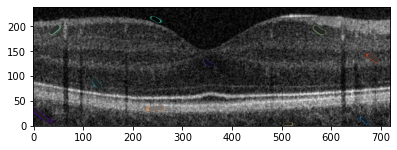


Iteration: 200
Time Remaining: 0 seconds
Fitness: [11.9, 11.8, 13.1, 12.8, 13.7, 13.9, 9.67, 13.2, 13.4, 14.3]
Mutation Rate: 0.00505
Tournament Size: 22

### PROFILING ###
Total program time: 39.09 sec
Function times:
- width: 0.11 sec (0.28%), 63300 calls
- length: 0.02 sec (0.04%), 63300 calls
- worm_spread: 1.32 sec (3.37%), 63300 calls
- cross_factor: 16.00 sec (40.94%), 63300 calls
- parallelism: 0.22 sec (0.55%), 63300 calls
- img_color_across_t: 2.50 sec (6.38%), 63300 calls
- path_colour: 4.51 sec (11.53%), 63300 calls
- colour_along_width: 8.67 sec (22.19%), 63300 calls
- outside: 0.88 sec (2.24%), 63300 calls
- get: 33.56 sec (85.87%), 63300 calls
- update: 33.72 sec (86.26%), 2000 calls
- avg_worm: 0.03 sec (0.07%), 100 calls



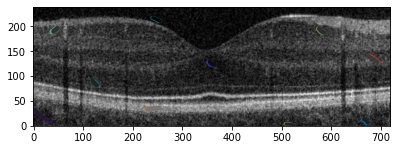

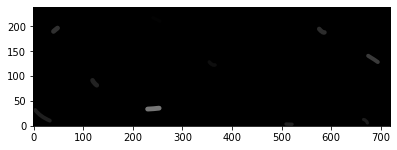

In [29]:
'''The Genetic Algorithm'''
# for profiling
start_time = time.time()
function_times = {}
profiling = True # change to True to see function times
# constants
iterations = 200
swarm_size = 30
num_swarms = 10
image = prep_image(IMAGE_DIR, "original", MASK)
swarms = [Swarm(image, initialise_clew(swarm_size, image.shape, (40, 30, 1))) for _ in range(num_swarms)]
fitness = Fitness(image, swarms)

# defining different images for testing
for s in swarms:
    s.fitness = fitness
    #s.tnm_k = 4
    #s.m_rate = 0.02

for it in range(iterations):
    fitnesses = []
    for swarm in swarms:
        # start the mutation rate high for a short time then keep it low for a long time (exponential)
        # allows for fast exploration at the start with fine tuning of the final solution at the end
        swarm.m_rate = 0.1 * np.exp(-3 * (it / iterations)) # -3 growth rate so it quickly decreases
        # same principle with tournament size, except that it starts low and increases over time
        # if tournament size = population, all children will come from the best parent (no diversity)
        swarm.tnm_k = max(int(len(swarm.population) / (1+np.exp(-5 * (it/iterations-0.8)))+1), 2) 
        swarm.update()
    if (it+1) % (iterations//10) == 0 or int(it) == 0:
        all_fitnesses = [sum(x) / len(x) for x in [[fitness.get(w) for w in p.population] for p in swarms]]
        print("Iteration:",it+1)
        print("Time Remaining:",int((time.time() - start_time) / (it+1) * (iterations - (it+1))),"seconds")
        print("Fitness:",[float(f"{x:.3}") for x in all_fitnesses])
        print(f"Mutation Rate: {swarms[0].m_rate:.3}")
        print(f"Tournament Size: {swarms[0].tnm_k}")
        if profiling:
            print_function_times()
        drawing = Drawing(image)
        for ix in range(len(swarms)):
            drawing.add_worms(swarms[ix].population, alpha=0.05, colour=(ix/len(swarms)))
            drawing.add_worms(swarms[ix].avg_worm())
        drawing.show()
        print()

drawing = Drawing(np.full((240,720),255))
for ix in range(len(swarms)):
    drawing.add_worms(swarms[ix].avg_worm())
drawing.show()

Image name (shape) (intensity max, min, mean, std)

averaged (240, 720) (182, 5, 49.4, 32.4)


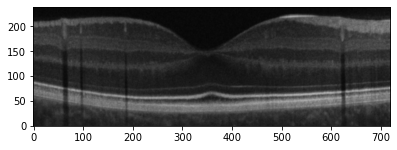

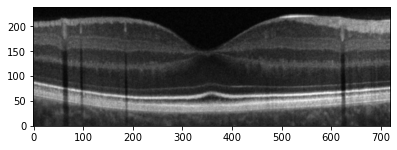

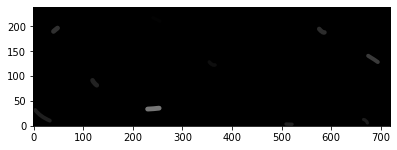

Image Variance: 0.11539162945619934


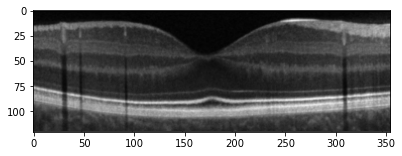

In [30]:
'''Performance Metric'''
# crops the wasted space out of the saved drawing plot
def crop_center_rectangle(image):
    height, width = image.shape[:2]
    left = int(width * 0.13)
    right = int(width * 0.90)
    top = int(height * 0.33)
    bottom = int(height * 0.68)
    plt.imshow(image[top:bottom, left:right], cmap='gray')
    return image[top:bottom, left:right]

# percentage variance between the images, pixel by pixel
def image_variance(current_image_path, averaged_image_path):
    # Read the images
    current_image = cv2.imread(current_image_path, cv2.IMREAD_GRAYSCALE)
    averaged_image = cv2.imread(averaged_image_path, cv2.IMREAD_GRAYSCALE)

    # Check if images are loaded successfully
    if current_image is None or averaged_image is None:
        print("Error: One or both images could not be loaded.")
        return None

    # Crop the images
    current_image = crop_center_rectangle(current_image)
    averaged_image = crop_center_rectangle(averaged_image)
    
    # Compute the squared difference between the images
    squared_diff = (current_image - averaged_image) ** 2
    
    # Compute the mean of the squared difference
    variance = np.mean(squared_diff)
    
    # Normalize variance by the maximum possible variance
    max_possible_variance = 255**2  # Maximum possible pixel value difference
    percentage_difference = (variance / max_possible_variance) * 100
    
    return percentage_difference

# putting the target image into a format we can compare our drawing to
avg_image = prep_image(IMAGE_DIR, "averaged", MASK)
imgs = Drawing(avg_image)
imgs.show(save=("images/avg_comparison"))
# plot the worms on a blank background
whites = np.full((240,720), 255)
drawing = Drawing(whites)
for ix in range(len(swarms)):
    drawing.add_worms(swarms[ix].avg_worm())
drawing.show(save=("images/final1"))
drawing = np.array(drawing.im)

# obtain the variance between the averaged image and the current drawn image obtained from the genetic algorithm above.
print("Image Variance: " + str(image_variance("images/final.png", "images/avg_comparison.png")))

In [31]:
# import imageio
# import numpy as np
# import time
# import os

''' FOR GENERATING TIMELAPSES OF THE MODEL's ITERATIONS '''
# # Setup directories for saving frames
# frames_dir = 'frames'
# os.makedirs(frames_dir, exist_ok=True)

# # Same setup code as before
# start_time = time.time()
# iterations = 200
# swarm_size = 50
# num_swarms = 5
# swarms = [Swarm(image, initialise_clew(swarm_size, image.shape, (40, 30, 1))) for _ in range(num_swarms)]
# fitness = Fitness(image, swarms)

# for s in swarms:
#     s.fitness = fitness

# # List to hold frame filenames
# frame_files = []
# count = 0

# for it in range(iterations):
#     count+=1
#     for swarm in swarms:
#         swarm.m_rate = 0.1 * np.exp(-3 * (it / iterations))
#         swarm.tnm_k = max(int(len(swarm.population) / (1+np.exp(-5 * (it/iterations-0.8)))+1), 2) 
#         swarm.update()
#     filename = f"{frames_dir}/frame_{str(count)}.png"
#     drawing = Drawing(image)
#     for ix in range(len(swarms)):
#         #drawing.add_worms(swarms[ix].population, alpha=0.05, colour=(ix/len(swarms)))
#         drawing.add_worms(swarms[ix].avg_worm())
#     drawing.show(save=filename)  # Assumes Drawing class has a save method
#     frame_files.append(filename)
#     print(f"Saved frame {it+1}")

# # Use imageio to create an MP4 video from the frames
# with imageio.get_writer('swarms_video.mp4', fps=10) as writer:
#     for filename in frame_files:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# # Optionally, clean up by removing frame files
# for filename in frame_files:
#     os.remove(filename)
# print("Video created successfully.")

" FOR GENERATING TIMELAPSES OF THE MODEL's ITERATIONS "